In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data Collection

In [2]:
deliveries = pd.read_csv(r"C:\Users\Nithya\Downloads\diminos_data_v2\diminos_data_v2\deliveries.csv")

In [3]:
order_items = pd.read_csv(r"C:\Users\Nithya\Downloads\diminos_data_v2\diminos_data_v2\order_items.csv")

In [4]:
orders = pd.read_csv(r"C:\Users\Nithya\Downloads\diminos_data_v2\diminos_data_v2\orders.csv")

In [5]:
products = pd.read_csv(r"C:\Users\Nithya\Downloads\diminos_data_v2\diminos_data_v2\products.csv")

### Data Cleaning

In [6]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363008 entries, 0 to 1363007
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   order_id    1363008 non-null  int64 
 1   time_stamp  1363008 non-null  object
 2   status      1363008 non-null  object
dtypes: int64(1), object(2)
memory usage: 31.2+ MB


In [7]:
deliveries["time_stamp"]=deliveries["time_stamp"].astype("datetime64")

In [8]:
deliveries.duplicated().sum()

0

In [9]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454336 entries, 0 to 454335
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   order_id       454336 non-null  int64 
 1   items_ordered  454336 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.9+ MB


In [10]:
order_items.duplicated().sum()

0

In [11]:
order_items["items_ordered"]=(order_items["items_ordered"].apply(lambda x:x.strip("[]").replace("'", '').split(","))).apply(lambda x:[item.strip() for item in x])

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454336 entries, 0 to 454335
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   order_id         454336 non-null  int64 
 1   order_placed_at  454336 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.9+ MB


In [13]:
orders["order_placed_at"]=orders["order_placed_at"].astype("datetime64")

In [14]:
orders.duplicated().sum()

0

In [15]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item_id   37 non-null     object
 1   category  37 non-null     object
 2   Item      37 non-null     object
 3   Size      37 non-null     object
 4   Price     37 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ KB


In [16]:
products.duplicated().sum()

0

### Merging the dataframes

In [17]:
df=deliveries.loc[deliveries["status"]=="Pending",["order_id","time_stamp"]].reset_index(drop=True).copy()

In [18]:
df["end_time"] = deliveries.loc[deliveries["status"]=="Delivered",["time_stamp"]].reset_index(drop=True)

In [19]:
df["delivery_time"]=(df["end_time"] - df["time_stamp"]).dt.total_seconds() / 60

In [20]:
df2=pd.merge(orders,order_items,on="order_id")

In [21]:
df=pd.merge(df,df2,on="order_id")

What is the average Delivery Time (in minutes) taken by the store to deliver the Pizza?

In [20]:
df["delivery_time"].mean()

20.647560770746257

What is the 99th percentile Delivery Time (in minutes) taken by the store to deliver the Pizza?

In [21]:
df["delivery_time"].quantile(0.99)

27.160349671800002

Which metric is the better choice to determine the stores performance based on Delivery Time?

In [22]:
df["delivery_time"].mean()

20.647560770746257

What is the order id with the maximum delivery time?

In [23]:
df.loc[df["delivery_time"]==max(df["delivery_time"]),"order_id"]

160475    321390589
Name: order_id, dtype: int64

How many pizza's were ordered between 1st January and 31st January 2024 (INCLUSIVE)?

In [24]:
len(df.loc[(df["order_placed_at"] >= '2024-01-01') & (df["order_placed_at"] <= '2024-01-31'),"items_ordered"].explode())

30336

How many order took more than 30 minutes to deliver between 1st January and 31st January 2024 (INCLUSIVE)?
*
This is important as Diminos promise 30 minutes delivery. For any pizza delivered after 30 minutes, customer will get a full refund.

In [25]:
len(df.loc[(df["order_placed_at"] >= '2024-01-01') & (df["order_placed_at"] <= '2024-01-31') & (df["delivery_time"] > 30)])

23

What is the total amount Pizza store lost in 2023 due to refunds on late deliveries?

In [34]:
l=df.loc[(df["order_placed_at"] >= '2023-01-01') & (df["order_placed_at"] <= '2023-12-31') & (df["delivery_time"] > 30),"items_ordered"].explode().value_counts()

In [47]:
df3=pd.DataFrame({"Count":l, "item_id":l.index})

In [50]:
df3=pd.merge(df3,products,on="item_id")

In [52]:
df3["Loss"] = df3["Count"] * df3["Price"]

In [55]:
df3["Loss"].sum()

238488

In which year Pizza store has lost maximum amount due to refunds on late deliveries?

In [77]:
gb = df.loc[df["delivery_time"] > 30,"items_ordered"].groupby(df["order_placed_at"].dt.year)

In [86]:
gb.sum().apply(lambda x:len(x))

order_placed_at
2020     46
2021    666
2022    673
2023    673
2024     62
Name: items_ordered, dtype: int64

How much revenue is generated by the pizza store till date? Don't include the refund amount in revenue.

In [91]:
k=df.loc[df["delivery_time"] < 30, "items_ordered"].explode().value_counts()

In [92]:
df4=pd.DataFrame({"Count":k, "item_id":k.index})

In [93]:
df4=pd.merge(df4,products,on="item_id")

In [94]:
df4["Loss"] = df4["Count"] * df4["Price"]

In [95]:
df4["Loss"].sum()

407086211

Which distribution can be used to model the number of orders incoming each hour? If we can somehow model it, which problem for owner of Pizza Store can be solved?

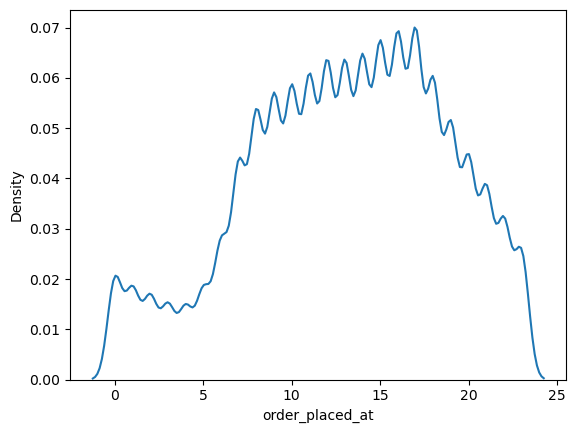

In [106]:
sns.kdeplot(df["order_placed_at"].dt.hour)
plt.show()